# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 32

**Author 1 (350508):** Ziyi ZHAO  
**Author 2 (321657):** Yujie HE   
**Author 3 (337088):** Xufeng GAO  

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import cv2 as cv
import numpy as np
import time
import tarfile
import skimage
import os
from PIL import Image
from skimage import filters
from skimage.feature import peak_local_max
from skimage import morphology
from skimage.segmentation import watershed
import statsmodels.api as sm
from scipy import ndimage as ndi
from skimage.filters.rank import gradient
from skimage.morphology import disk
from skimage import exposure
from skimage.exposure import histogram, cumulative_distribution, equalize_hist
from skimage import color
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import webcolors
import warnings
warnings.filterwarnings('ignore')

In [2]:
#data_base_path = os.path.join(os.pardir, 'data')
data_base_path = os.path.join('/home/my_notebooks/iapr', 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by
Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* An additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment
each method limitations and/or advantages.

### 1.1 Brain image visualization

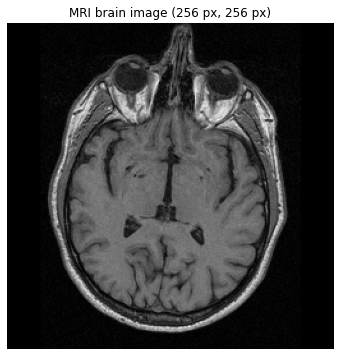

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [4]:
# function to plot multiple images
def plotMultipleImages(nrows, ncols, images, titles, cmap):
    fig = plt.figure(figsize=(14,7))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    for i in range(len(titles)):
        ax = fig.add_subplot(nrows, ncols, i+1)
        if cmap[i]=='rgb':
            ax.imshow(images[i])
        else:
            ax.imshow(images[i], cmap=cmap[i])
        ax.set_title(titles[i])
    plt.show()

In order to compute the size of brain (without the skull) in pixels, differnet methods are used to segment the brain object from the original image. Before we apply different algorithms to implement the image segmentation, the original MRI image should be pre-processed to improve its quality so that we can analyse it in a better way. Since each algorithm has different characteristics, differnet pre-processing methods will be considered on a case-by-case basis.

### 1.2 Region growing (5pts)

#### 1.2.1 Pre-processing

The basic idea of region growing is to assemble pixels with similar properties to form regions. There are different criteria available for determining region membership. In this lab, we use the intensity difference between neighbor or connected pixels as the growth criteria. The goal is to extract the gray area of brain from skull (relatively bright = high intensity, but mixed with gray parts) and backgroud (totally dark = low intensity). Our idea is, if the intensity difference of these three objects can be increased further, the brain can be easier identified so that the performance of the region growth should be better. Thus, we firstly plot the histogram of provided MRI brain image to check the pixel intensity distribution.

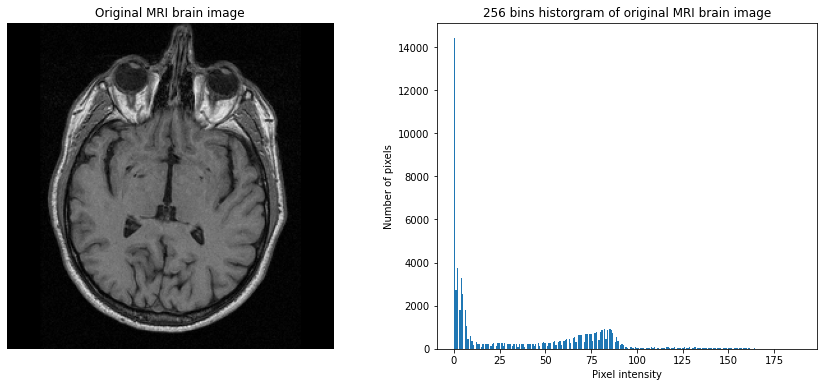

The intensity value of brain center is 79


In [5]:
# Draw image histogram 
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('Original MRI brain image')
ax[0].axis('off') 
ax[1].hist(brain_im.ravel(), bins=256) 
ax[1].set_title('256 bins historgram of original MRI brain image')
ax[1].set_xlabel('Pixel intensity')
ax[1].set_ylabel('Number of pixels')
plt.show()
print('The intensity value of brain center is {}'.format(brain_im[150,150]))

As the histogram shows, the following observations can be obtained:
1. The bars are spread out over the x-axis, which means the histogram equalization may not be required in this part as the image contrast is enough; 
1. It's possible to identify two clusters of pixels. The first cluster around 0-intensity should be the dark background; The 2nd cluster covers the intensity valus from 50 to 100. The intensity value of brain center we found is 79, which suggests that the 2nd cluster mainly corresponds to the gray brain.
1. The remaining pixels could be, for example, the overlapping parts of the brain and skull, noise, or transition areas between background and foreground.

Thus, two pre-preocessing methods were suggested:
- As the distribution of histogram is nicely bimodal, we can apply a threshold range to filter out the parts that are not of interest (i.e., the background, the brighter parts of the skull) so that the region growing used in later can easier capture the brain tissue that is remained in the image. 
- To address the noise issue. the low-pass filter, median kernel, is to remove any possible noise off the image while preserving the countours of objects.

(Note: These pre-processing methods are conducted several times, and all parameters (i.e., kernel size and threshold value) are selected carefully to keep most relevant parts of our analysis)

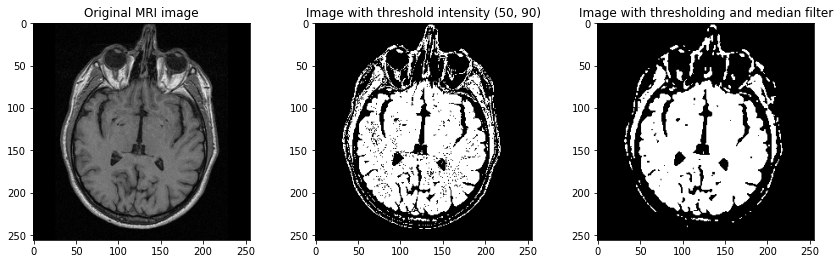

In [6]:
# threshold to extract intensity values between 54 and 90
thres_brain_im = cv.inRange(brain_im,54,90)

# median filter with kernel = 3
median_brain_im = cv.medianBlur(thres_brain_im, 3)

titles = ['Original MRI image', 'Image with threshold intensity (50, 90)', 'Image with thresholding and median filter']
images = [brain_im, thres_brain_im, median_brain_im]

plotMultipleImages(1, 3, images, titles, cmap=['gray']*3)

As the results show, after applying the pre-processing, certain brighter parts of the skull are filtered out and the connection between brain and skull is weaken. Now the image is cleaner than before.

#### 1.2.2 Implementing region growing

In this part, we used our own region growing function to segment the brain. Specifically, our implementation consists of 3 steps:
1. It requires priori knowledge of the image. The user is requested to select the seed according to its need. As our goal is to extract the brain part from image, we put the seed in the center part of brain (i.e., height=150, width=150) which makes the brain region grow easier and faster.
1. Taking the seed as center, consider 4-connected neighbor pixels. For neighbors, that can meet the growth criteria and are not labelled before, will be asigned with the same label as seed. Furthermore, these neighbors will be used as new seeds for growing current region further. For neighbors that are not consistant with seed, we just ignore them. 
1. Repeating above steps until the new_seeds list becomes empty, whcih means that all pixels included in the brain region have been collected.


Note: (1) Becasue the current image is in binary format (i.e., 0 for background and 255 for brain), the growth criteria we used is that only neighbors that have intensity of 255 will be merged into the region where the seed is located. (2) We also tested with the 8-connectivity neighbors to check if the accuracy of segmentation could be further improved. Then the results showed that, in this case, the improved accuracy is quite limited and the execution time of 8-connectivity case is 1.96 times longer than before. Thus, we finally decided to use 4-connectivity neighbor pixels only.

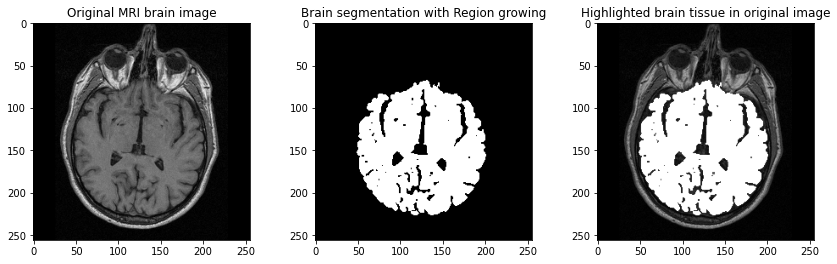

The total area of brain is 16409 pixels from the region growing method.


In [7]:
# region growing algorithm
def regionGrowing(start_seed, original_im, connect=4):
    
    # matrix to store gray value of labelled pixel
    regionMask_im = np.zeros(original_im.shape)
    
    if connect == 4:
        # relative position of connected pixels: left, right, above, below
        neighbor_pos = [(0, -1), (0, 1), (1, 0), (-1, 0)]
    if connect == 8:
        # connected neighbor pixels: left, right, above, below, diagonal
        neighbor_pos = [(0, -1), (0, 1), (1, 0), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]
        
    new_seeds = [start_seed]
    labelled_point = [start_seed]
    
    while(len(new_seeds) != 0):
        
        seed = new_seeds.pop(0) # pop up the 1st seed
        regionMask_im[seed] = 255 # set seed pixel to white
        labelled_point.append(seed)
        
        # traverse all neighbors
        for pos in neighbor_pos:
            # get neighbor position and check if it is inside the image
            neighbor = (seed[0] + pos[0], seed[1] + pos[1])
            if neighbor[0] < 0 or neighbor[0] >= original_im.shape[0] or neighbor[1] < 0 or neighbor[1] >= original_im.shape[1]:
                continue
            # check constrast difference & assigin label
            if (np.abs(int(original_im[seed]) - int(original_im[neighbor]))) == 0 and neighbor not in labelled_point and neighbor not in new_seeds:
                new_seeds.append(neighbor)

    return regionMask_im, len(labelled_point)

# start point
start_seed = (150, 150)
regionMask_im, brain_area = regionGrowing(start_seed, median_brain_im, 4)
regionMask_im = regionMask_im.astype(np.uint8)

# keep brain tissue part
brain_out = np.copy(brain_im)
brain_out[regionMask_im==255] = 255

# comparison
images = [brain_im, regionMask_im, brain_out]
titles = titles = ['Original MRI brain image', 'Brain segmentation with Region growing', 'Highlighted brain tissue in original image']
plotMultipleImages(1, 3,images, titles, cmap=['gray']*3)

# count the brain area
print('The total area of brain is {} pixels from the region growing method.'.format(brain_area))

As the final result shows, the brain part (without the skull) has been successfully extractd from the original MRI image. 

### _Comment:_ 
The region growing algorithm is a simple method, which only needs a small number of seed points to represent the property we want, then grows the region by using a recursive process. In our case, the segmentation result is quite reliable. However, it also has some limitations that we found in this lab. For example, the variation of intensity may cause result in holes or oversegmentation. In our case, the MRI images have a good bimodal intensity distribution, so a simple threshold processing can effectively weaken the connection between the brain and the skull, and then the growing region starting from the center of the brain will not contain the skull object by a weak connection. However, 
unless image has had a threshold function applied, a continuous path of points related to color may exist, which connects any two points in the image.

### 1.3 Contour detection (5pts)

In Image Processing, an edge refers to a set of continuous points where a significant local change in the image brightness can be observed, which is usually associated with a discontinuities in either the image intensity or the first derivative of the image intensity. When these edge points are joining to form a closed boundary, the contour is obtained which sepertes two homogeneous regions. And the process of identifying and locating sharp discontinuities in an image is known as edge detection. Many edge-based algorithms are to pation a digital image into multiple regions based on detecting abrupt changes in charactristics such as tecture, intensity, or color. For example, some commonly used methods, Robers operator, Sobel operator and Previtt operator, compute or estimate the 2-D intensity gradient vector at each pixel by convolving image with horizontal and vertical derivative filters. In this part, we choose **Sobel operator** as the contour dtector as it has the advantage of providing differentiating (which gives the edge response) and smoothing (which reduces noise) concurrently. 

#### 1.3.1 Pre-processing

Before we implement contour detection, it should be noted from the process of Part-1.2 that the original MRI image is quit noisy (i.e. The noise reduction provided by the Sobel operator itself may not be sufficient). Since both the edges and noise hold high-frquency content, an appropriate filtering (**i.e. Gaussian smoothed**) is essential in pre-processing to reduce potential problems caused by noise such as fake edge detection, edge localizytion or missing true edges.

In general, we can identify 3 kinds of edges from the results:
1. Strong edges that have an intensity so high that we are sure they contribute to the brain object, such as the edges of skull and part of brain tissue.
1. Weak edges that have relatively low intensity values but are still visible, such as the light pattern of brain.
1. Some irrelevant edges (i.e., residual noise) contained in the background may not be visible to us from the image, but they are present. Thus our goal is to extract the edges of the brain tissue that define the area of entire brain (without skull). 

However, after trying different extraction methods (i.e. thresholding with fine-tuning parameters), We found that the irrelevant edges were easily eliminated, but it was impossible to separate the edges of the skull from the edges of the brain tissue because their edges had similar intensities. Thus, we decided to temporarily preserve the edges of skull and brain tissue and remove irrelevant edges only by using a simple threshold method. The threshold value was chosen to be the mean intensity of Sobel_brain_im to keep the most relevant edges of brain for our further analysis.

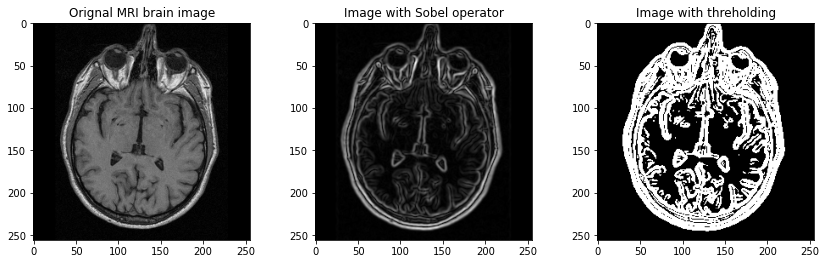

In [8]:
# Smooth the image for better edge detection
Gaussian_brain_im = cv.GaussianBlur(brain_im, (5,5), 0)

# Sobel Edge Detection
Sobel_brain_im = filters.sobel(Gaussian_brain_im)

# threshold
_ ,thres_brain_im = cv.threshold(Sobel_brain_im, np.mean(Sobel_brain_im)*1, 255,cv.THRESH_BINARY)

images = [brain_im, Sobel_brain_im, thres_brain_im]
titles = titles = ['Orignal MRI brain image', 'Image with Sobel operator', 'Image with threholding']
plotMultipleImages(1, 3,images, titles, cmap=['gray']*3)

#### 1.3.2 Implementing contour detection

The results show that the skull is mainly composed of white pixels, while the brain tissue is mainly composed of black pixels. We then realized that the brain tissue can be extracted by subtracting the current image (caption: 'image with thresholding') from a binary image consisting of black background and a white brain (skull + brain tissue). To achieve this, the function `binary_fill_holes()` is used to an binary brain image. Then  operation `remove_small_objects()` is used to remove residual skull pixels. Finally, the morphological dilation is used to fill undesired holes in brain tissue.

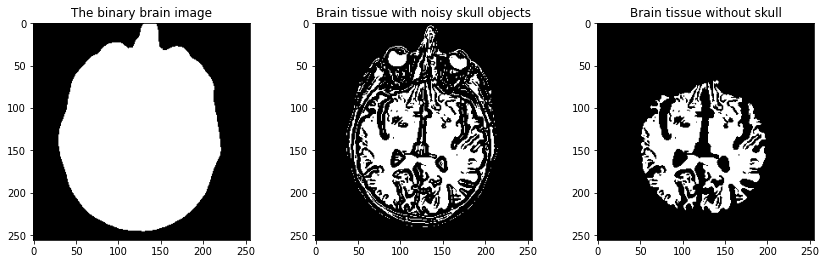

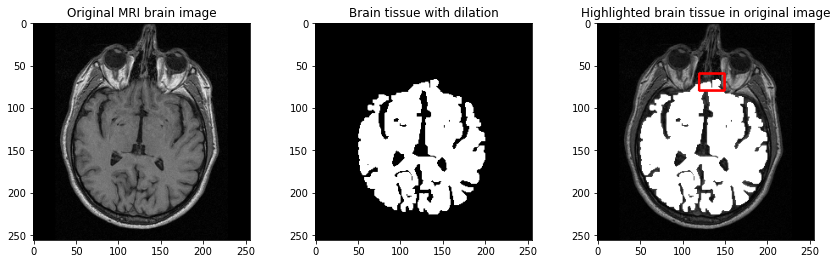

The total area of brain is 15408 pixels from the contour detection.


In [9]:
# Extract entire brain object
bi_brain_im = ndi.binary_fill_holes(thres_brain_im).astype(np.uint8)

# compute the difference
diff_brain_im = np.abs(thres_brain_im - bi_brain_im*255)

# remove undesired objects
clean_brain_im = morphology.remove_small_objects(diff_brain_im.astype(bool), min_size=300)

# fill small holes contained in brain tissue
kernel = np.ones((4,4),np.uint8)
dilation = cv.dilate(clean_brain_im.astype(np.uint8),kernel,iterations = 1)

# display results
images = [bi_brain_im, diff_brain_im, clean_brain_im]
titles = ['The binary brain image',  'Brain tissue with noisy skull objects', 'Brain tissue without skull']
plotMultipleImages(1, 3,images, titles, cmap=['gray']*3)

# compare to original MRI image
brain_out = np.copy(brain_im)
brain_out[dilation==1] = 255

brain_out = cv.cvtColor(brain_out, cv.COLOR_GRAY2RGB)
brain_out = cv.rectangle(brain_out, (120, 60), (150, 80), (255,0,0), 2)
images = [brain_im, dilation, brain_out]
titles = titles = ['Original MRI brain image', 'Brain tissue with dilation', 'Highlighted brain tissue in original image']
plotMultipleImages(1, 3,images, titles, cmap=['gray', 'gray', 'rgb'])

# count the brain area
print('The total area of brain is {} pixels from the contour detection.'.format(np.count_nonzero(dilation)))

### _Comment:_ 

From above plots, we can see that the contour detection also gives quite accurate results to segment the brain tissue. However, due to the image subtraction we used, the edges of brain tissue is thinned so that the number of pixels counted from the brain tissue is slightly less than the one we found with the region growing method. Moreever, we found that it requires  has though a drawback as it requires human intervention to choose which edges to include or exclude. Sometimes, it is even difficult for a human to decide just looking at the picture. For example, in areas where brain tissue and skull are in close proximity, the edges cannot be seperated well with thresholding, so that some image artifacts are produced due to residual edges of skull (shown in red box). Therefore, we can infer that the edge detection method may not segment the overlapping objects well. 

### 1.4 Additional method (5pts): Watershed transformation
The watershed transformation is a region-based segmentation algorithm, which is especially useful when extracting touching or overlapping objects in images, such as the skull and brain tissue in our MRI image above. It only works on grayscale images. The intuitive idea underlying this method comes from geography: it condiders any greytone image as a topographic landscape with ridges and valleys, and the elevation value of the landscape is usually defined by the grayscale value of each pixel or its gradient size. 

This algorithm requires the selection of markers (like the “seed” in region growing method) to characterize the interior object of the image. These markers can be manually defined (like we did in region growing part), but here we want to automatically define them using some powerful functions from python library. After that, the watershed algorithm starts to “flood” valleys (local minimum) with different colored water (label) from the markers and moves outwards, until the filling water of different valleys meet each other (but is not allowed to mix). The dams need to be built at the points of first contact. These dams we call watershed lines are used to determine the boundaries of image objects. At the end of the process, only watershed lines will be visible and that will be the final segmentation result.

#### 1.4.1 Image preprocessing
- In practice, noise or local irregularities in the image may cause Watershed transformation produce a large number of small regions. This is known as over-segmentation. Therefore, we apply a median filter to filter out those noises while preserving the object contours that are important for building the watershed line.
- Then we apply thresholding to find an approximate estimate of the brain.
- After that, morphological opening is used to remove some small white noise residuals and skulls in the image to make subsequent segmentation easier.  

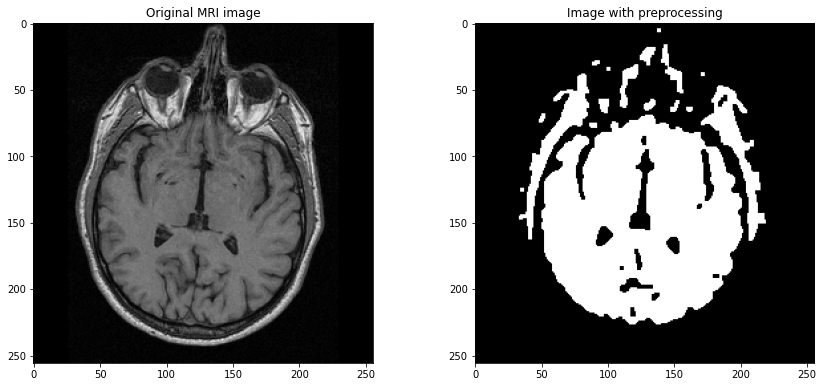

In [10]:
# median filter with kernel = 3
median_brain_im = cv.medianBlur(brain_im, 5)

# thresholding
thres_brain_im = cv.inRange(median_brain_im,54,90)

#Gaussian_brain_im = cv.GaussianBlur(thres_brain_im, (3,3), 0)

# morphological opening
kernel = np.ones((3,3),np.uint8)
morph_brain_im = cv.morphologyEx(thres_brain_im, cv.MORPH_OPEN, kernel)
morph_brain_im = cv.morphologyEx(morph_brain_im, cv.MORPH_CLOSE, kernel)
titles = ['Original MRI image', 'Image with preprocessing']
images = [brain_im, morph_brain_im]

plotMultipleImages(1, 2, images, titles, cmap=['gray']*2)

#### 1.4.2 Implementing watershed transformation
- The key problem that we need to solve is how to create an image with markers to which we will apply the Watershed algorithm. Our first choice may be to apply the **Gradient magnitude method** on the image. Because the image now becomes binary, only two values are possible for the magnitude of the gradient (0 and 255). '0' gradient is for continuous regions (i.e., black background and white brain), while '255' gradient is always positioned at the sharp transitions from background to brain and vice versea. 
- Thus the markers used can be extracted by **labeling low gradient regions** that are equal to 0, which corresponds to the 'valleys'. 
- After that, watershed transformation is used to 'flood' these valleys with different colored water. 
- As the result shows, background, brain tissue, and some skull residuals are marked in different colors. 
- Finally, we keep the region of interest, which is the brain

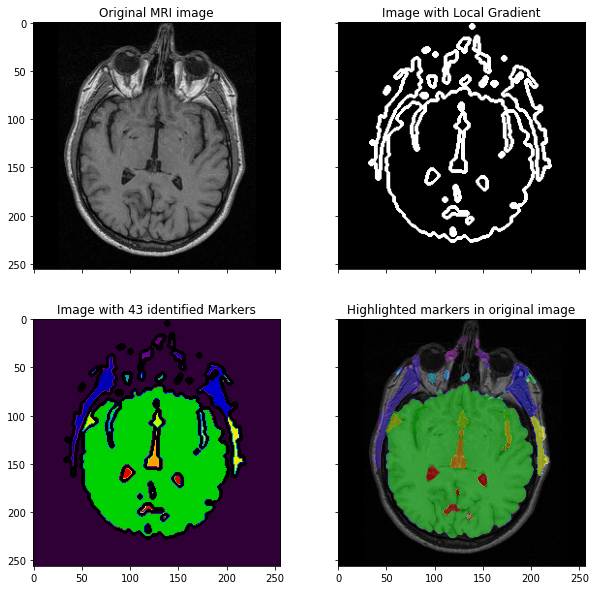

In [11]:
# local gradient (disk(2) is used to keep edges thin)
gra_brain_im = gradient(morph_brain_im, disk(2))

# find markers
markers_brain_im = gra_brain_im < 255
markers_brain_im, num_markers = ndi.label(markers_brain_im)

# watershed transformation
ws_brain_im = skimage.segmentation.watershed(gra_brain_im, markers_brain_im)

# Display results
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(10, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('Original MRI image')

ax[1].imshow(gra_brain_im, cmap='gray')
ax[1].set_title('Image with Local Gradient')

ax[2].imshow(markers_brain_im, cmap='nipy_spectral')
ax[2].set_title('Image with {} identified Markers'.format(num_markers))

ax[3].imshow(brain_im, cmap='gray')
ax[3].imshow(ws_brain_im, cmap='nipy_spectral', alpha=0.5)
ax[3].set_title('Highlighted markers in original image')

plt.show()


The total area of brain is 17122 pixels from the watershed transformation.


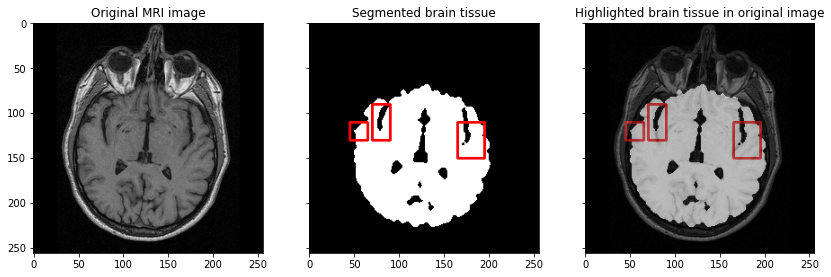

In [12]:
# keep the brain tissue part only
values, counts = np.unique(ws_brain_im, return_counts=True)
brain_tissue = sorted(list(zip(values, counts)), key=lambda x: x[1])[-2]

print('The total area of brain is {} pixels from the watershed transformation.'.format(brain_tissue[1]))

brain_out = np.copy(ws_brain_im).astype(np.uint8)

brain_out[brain_out != brain_tissue[0]] = 0
brain_out[brain_out == brain_tissue[0]] = 255

brain_out = cv.cvtColor(brain_out, cv.COLOR_GRAY2RGB)
brain_out = cv.rectangle(brain_out, (70, 90), (90, 130), (255,0,0), 2)
brain_out = cv.rectangle(brain_out, (165, 110), (195, 150), (255,0,0), 2)
brain_out = cv.rectangle(brain_out, (45, 110), (65, 130), (255,0,0), 2)
# Display results
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(14, 14),
                         sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('Original MRI image')

ax[1].imshow(brain_out)
ax[1].set_title('Segmented brain tissue')

ax[2].imshow(brain_im, cmap='gray')
ax[2].imshow(brain_out, cmap='gray', alpha=0.5)
ax[2].set_title('Highlighted brain tissue in original image')

plt.show()

### Comments for watershed with gradient metric
The watershed gives a good segmentation results here, but the brain tissue area measured here is larger than the number we got from region growing method. From the plots, we can see that it introduces artiffacts on brain edges and reduces long gaps on brain tissue (shown in red boxes). Moreover, from the image ('image with 56 identified markers'), we can see that some small markers that are not supposed to be there are captured due to residual noise. This is because our first choice the **Gradient magnitude method** `gradient()` is highly sensitive to local maxima/minima, which in practice easily produces an over-segmented result due to noise or some other irregularities in the image. This issue can become more serious in practical applications. To obtain more accurate markers, we can use the watershed algorithm with another metric called **distance transform method**.

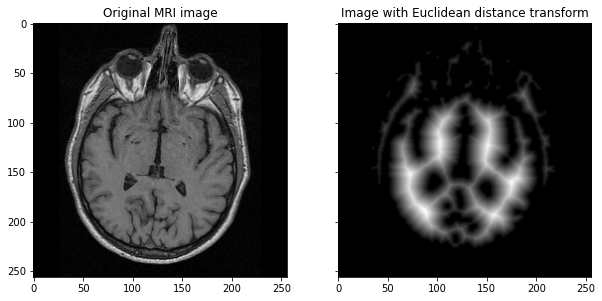

In [13]:
# distance metric
dist_transform = cv.distanceTransform(morph_brain_im, cv.DIST_L2,3)

# Display results
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('Original MRI image')

ax[1].imshow(dist_transform, cmap='gray')
ax[1].set_title('Image with Euclidean distance transform')
plt.show()

Function `dist_transform` takes images as inputs and pixel intensities of the points inside the foreground regions are replaced by their distance to the nearest pixel with zero intensity (background pixel). For the parameter `distanceType` we can choose several different types of a distance transform. In our code, we are using a simple Euclidean distance. The greater the distance, the brighter the pixels.

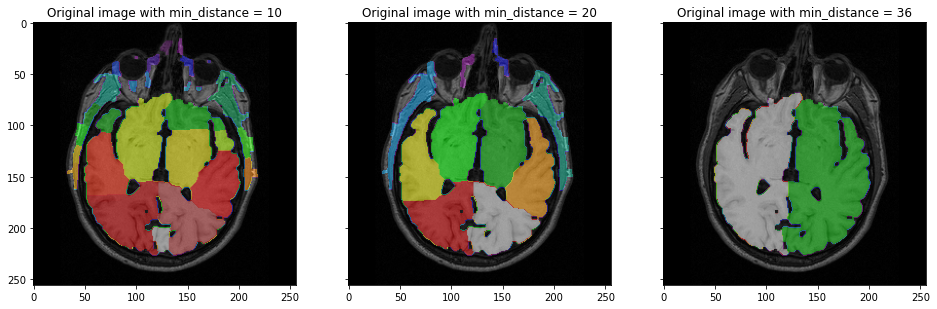

In [14]:
min_distances = [10, 20, 36]
ws_brain_ims = []
for min_distance in min_distances:
    # find local maxima which corresponds to the brain tissue here
    local_max_boolean = peak_local_max(dist_transform, min_distance=min_distance, indices=False)
    # assign labels
    markers_brain_im, num_markers = ndi.label(local_max_boolean)
    # watershed transformation
    ws_brain_im = skimage.segmentation.watershed(255-dist_transform, markers_brain_im, mask=morph_brain_im)

    ws_brain_ims.append(ws_brain_im)
    
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(16, 16), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(brain_im, cmap='gray')
ax[0].imshow(ws_brain_ims[0], cmap='nipy_spectral', alpha=0.5)
ax[0].set_title('Original image with min_distance = {}'.format(min_distances[0]))

ax[1].imshow(brain_im, cmap='gray')
ax[1].imshow(ws_brain_ims[1], cmap='nipy_spectral', alpha=0.5)
ax[1].set_title('Original image with min_distance = {}'.format(min_distances[1]))

ax[2].imshow(brain_im, cmap='gray')
ax[2].imshow(ws_brain_ims[2], cmap='nipy_spectral', alpha=0.5)
ax[2].set_title('Original image with min_distance = {}'.format(min_distances[2]))
plt.show()

Then `peak_local_max` is used to find the coordinates of the peaks (local maxima) of the white areas in the image to treat them as markers that are rquired in watershed algorithm. From the results, all resultant markers are quite reasonable now, which correspond to real objects of image. The noise/irregularities markers we bothered before are no longer issues. This means that the watershed algorithm based on distance metric is more robust to noise than the one based on gradient metric. The parameter **min_distance** determines how spread the markers are. As we can see, a small **min_distance** may include unwanted markers that correspond to the regions of skull. 36 is the minimun value we found that can mark all brain tissue areas.

The total area of brain is 16906 pixels from the watershed transformation.


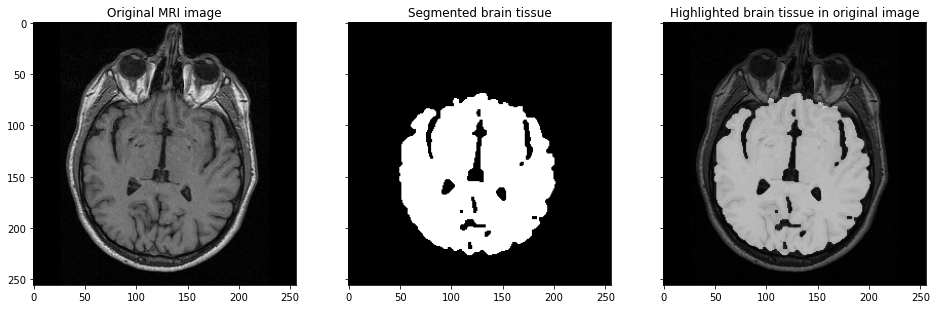

In [15]:
# only consider the case with min_distance = 36
ws_brain_im = ws_brain_ims[2]

# the non-background objects have non-zero label, now assign them with 255 (white color)
ws_brain_im[ws_brain_im != 0] = 255

# count the pixels of background and brain tissue
_, counts = np.unique(ws_brain_im, return_counts=True)

# give results
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(16, 16), sharex=True, sharey=True)
ax = axes
ax[0].imshow(brain_im, cmap='gray')
ax[0].set_title('Original MRI image')

ax[1].imshow(ws_brain_im, cmap='gray')
ax[1].set_title('Segmented brain tissue')

ax[2].imshow(brain_im, cmap='gray')
ax[2].imshow(ws_brain_im, cmap='gray', alpha=0.5)
ax[2].set_title('Highlighted brain tissue in original image')

print('The total area of brain is {} pixels from the watershed transformation.'.format(np.sort(counts)[0]))

### Comments for watershed with distance metric
We can see that the result is much better than the one we got before. The shape of segmented brain tissue is more natural now, which is quite close to the one shown in original object. Moreever, it exclude the gaps on brain tissue this time, which makes the calculated brain area more accurate. 

### Conclusion for part 1

In summary, we tried 3 different methods to segment the brain tissue, and the results we obtained are quite similar to each other. It seems that the region growing method is the best one here as it can not only seperate the brain tissue form other objects but also capture more detains on brain tissue (i.e., wrinkles and gaps). We can see that the image prepreossing is quite essential for these methods. Inappropriate preprocessing will cause totally different segmentation results. Parameters fine-turing are required in these methods.

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [16]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
#im_names = ['girl', 'girl', 'girl']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape)
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  (3, 480, 640, 3)
Image size: 480, 640 
Number of color channels:  3


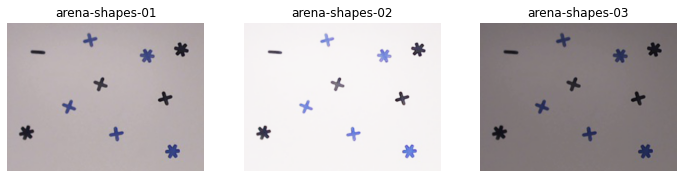

In [17]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

#### 2.1.1 Histogram

For a grey-scale image, the distribution of grey levels per pixel is an important feature of that image. The histogram of an image depicts the distribution of greyscales in the image and provides a visual representation of how much of the image is occupied by each greyscale class.

However, For colour images, direct histograms can yield less information than grey-scale maps, but a differentiated image channel can be used to obtain a per-channel histogram to aid analysis, which is of great value.

To facilitate the following work, the histogram for all images are first plotted and compared here 

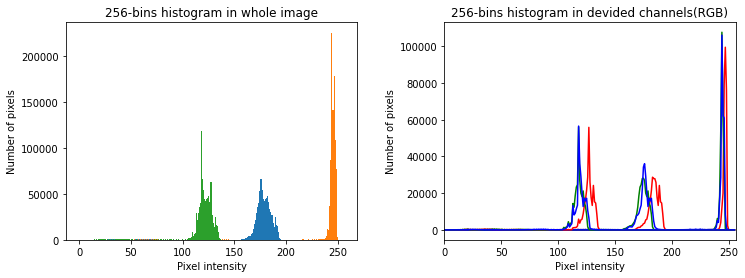

In [18]:
# plot the histogram of the images 
color = ('r','g','b')

fig, ax = plt.subplots(1,2,figsize=(12,4))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# firstly, we show a general histogram distribution for whole image (RGB channels are not seperated)
plt.subplot(1,2,1)
for im in images:
    plt.hist(im.ravel(), 256, [0, 256]) 
    plt.xlabel('Pixel intensity')
    plt.ylabel('Number of pixels')
    plt.title('256-bins histogram in whole image')

# Then we check the histogram distribution for each chall
plt.subplot(1,2,2)
for im in images:
    i=0
    for i,col in enumerate(color):
        histr = cv.calcHist([im],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
    plt.xlim([0,256])
    plt.xlabel('Pixel intensity')
    plt.ylabel('Number of pixels')
    plt.title('256-bins histogram in devided channels(RGB)')
plt.show()

#### Comments

We can see that:
* The RGB channels in one image are relatively concentrated, besides there is linear characteristics shown between the images, meaning image segmentation via RGB channels can be cumbersome but it would be advantageous to use other colour models that can separate the luminance separately. 
* The peaks of the three pictures are different from each other, which also confirms the different lighting conditions of the three pictures as the different lighting conditions cause significant differences in the grey scale of the images. 

So the next step is to perform image space conversion from an RGB model to an HSV or LSB model based on the basic image preprocessing.

### 2.2 Number of shapes of each color (5 pts)

Algorithm: 

- Input:  single image
- Process:  image analysis - colour classification - shape classification 
- Output:  colours and corresponding shapes 

Function list:

- plotMultipleImages(nrows, ncols, images, titles, type, cmap=False) --> none
- analysis(self, frame)--> contours, self.vertex, self.col_hsv, self.col_rgb, self.pixels
- color_filter(col_hsv, col_rgb, contours) --> col_obj_1, col_obj_2, color, obj
- shape_identify_pixels(objs, pixels, listOfKeys)--> obj_num 
- get_colour_name(requested_colour)--> actual_name, closest_name
- resaul_print --> none

In [19]:
# define a function for ploting multiple images
def plotMultipleImages(nrows, ncols, images, titles, type, cmap=False):
    if type=='typ_img':
        fig = plt.figure(figsize=(10,4))
        # fig.set_tight_layout(True)
        fig.subplots_adjust(hspace=0.4, wspace=0.3)
        for i in range(len(titles)):
            ax = fig.add_subplot(nrows, ncols, i+1)
            if cmap==False:                
                ax.imshow(images[i])
            else:
                ax.imshow(images[i], cmap='gray')
            ax.set_title(titles[i])
            ax.axis('off')
    else:
        fig = plt.figure(figsize=(10,4))
        fig.subplots_adjust(hspace=0.4, wspace=0.3)
        for i in range(len(titles)):
            fig.add_subplot(nrows, ncols, i+1)
            if images[i].max() > 1.01:
                plt.hist(images[i].ravel(), 256, [0, 256])
            else:
                plt.hist(images[i].ravel(), 100, [0, 1]) 
            plt.title(titles[i])
            # ax = plt.gca()
            # ax.axes.xaxis.set_ticks([])
            # ax.axes.yaxis.set_ticks([])
    plt.show()

#### 2.2.1 Analysis

Because the main difference between these 3 images is the brightness, the segmentation methods we used in section 1 cannot be directly used here. Thus, the RGB images are converted to the HSV format, so that we can isolate the brightness value (which corresponds to V-channel) of images.

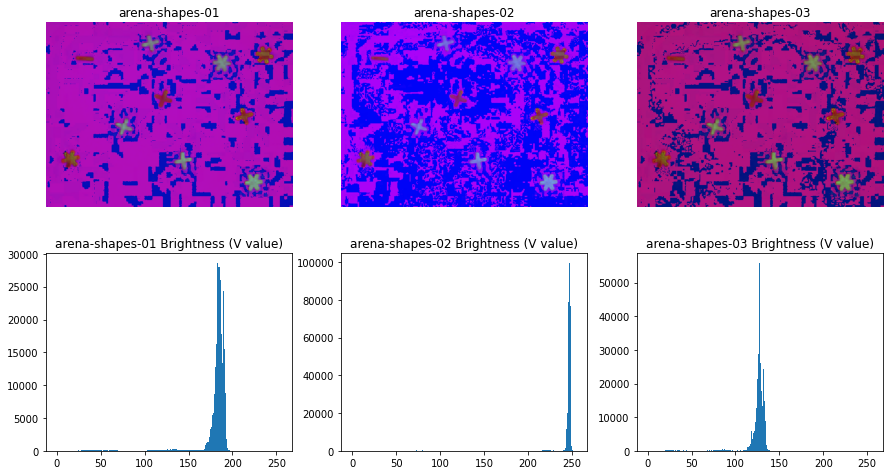

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, im, nm in zip(range(3), images, im_names):
    # channel conversion
    HSV_im = cv.cvtColor(im, cv.COLOR_RGB2HSV)                             
    axes[0,i].imshow(HSV_im)
    axes[0,i].axis('off')
    axes[0,i].set_title(nm)
    axes[1,i].hist(HSV_im[:,:,2].ravel(), 255, [0,255])                     
    axes[1,i].set_title(nm + " Brightness (V value)")
plt.show()

As the plots show, the brghtness distrinution for these 3 images are quite different. The middle image is brightness, but gives the worst contrast. The other two images are darker, but have better contrast. In order to make the further processing easier, we tried different preprocessing methods to enhace the contrast and brightness. 

#### 2.2.2 Contrast and brightness enhancement

By definition, **brightness** refers to the overall lightness or darkness of the image, and **contrast** is the difference in brightness between objects or regions. When image is in HSV format, we can easily change the brightness and contrast by adjusting the V-channel intensities. Thus, the enhancement methods we proposed in folowing sectons would focus on the V-channel 


Here we introduce one method of enhancing image contrast and brightness: `g(i,j)=α⋅f(i,j)+β`, where the parameters `α>0` and `β` are often called the gain and bias parameters; sometimes these parameters are said to control contrast and brightness respectively. And `i` and `j` indicates that the pixel is located in the i-th row and j-th column.

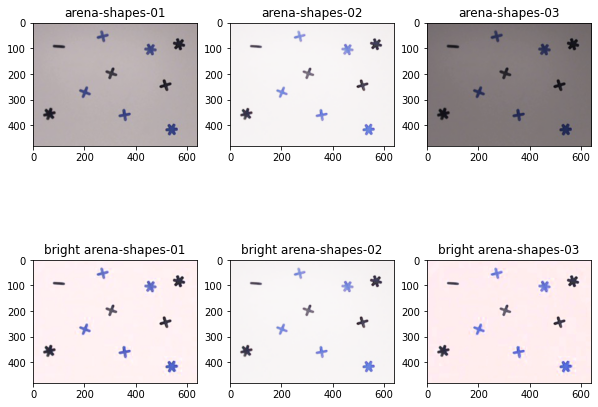

In [21]:
def enhance_im(rgb_in_im, alpha=1, beta=0):
    #new_im = np.zeros(old_im.shape, old_im.dtype)
    hsv_in_im = cv.cvtColor(rgb_in_im, cv.COLOR_RGB2HSV)
    h, s, v = cv.split(hsv_in_im)
    v = cv.convertScaleAbs(v, alpha=alpha, beta=beta)
    hsv_out_im = cv.merge((h,s,v))
    rgb_out_im = cv.cvtColor(hsv_out_im, cv.COLOR_HSV2RGB)
    
    return rgb_out_im.astype(np.uint8)

output1 = enhance_im(images[0], alpha=1.5, beta=3)
output2 = enhance_im(images[1], alpha=1, beta=1)
output3 = enhance_im(images[2], alpha=2.5, beta=3)
bright_images = [output1, output2, output3]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes[0][0].imshow(images[0])
axes[0][0].set_title(im_names[0])

axes[0][1].imshow(images[1])
axes[0][1].set_title(im_names[1])

axes[0][2].imshow(images[2])
axes[0][2].set_title(im_names[2])

axes[1][0].imshow(output1)
axes[1][0].set_title("bright "+im_names[0])

axes[1][1].imshow(output2)
axes[1][1].set_title("bright "+im_names[1])

axes[1][2].imshow(output3)
axes[1][2].set_title("bright "+im_names[2])
plt.show()

**Observations:** As the reuslts show, the image brightness and contrast is improved effectly by using this method. Now these 3 bright images can be used directly with our algorithms developed later.

**Limitations:** Using tha `β` bias may increase brightness, but at the same time the image will appear slightly veiled as the contrast will be reduced. The `α` gain can be used to dampen this effect, but due to saturation we will lose some detail in the original bright areas. Thus, appropriate parameter fine-turning is required.

#### 2.2.3 Image Analysis

Work Flow: 

1. Convert origin image to Binary form
2. Capture the contours
3. Calculate the center coordinate of each object
4. Extract the color of the object through coordinates 

In [22]:
"""
    Define a class for object and colour analysis in pictures.
        Input: single image H*W*C where c=3
        Output: four lists of data for contours, vertex, col_hsv, col_rgb
"""

class Img_Analysis:

    def analysis(self, frame):
        self.col_rgb = []
        self.col_hsv = []
        self.vertex = []
        self.pixels = []
        
        h, w, ch = frame.shape
        result = np.zeros((h, w, ch), dtype=np.uint8)

        # rgb->binary
        # Perform image greyscaling and threshold segmentation
        gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
        ret, binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
        thresh =cv.Canny(binary, 50, 100)

        # Contour detect and visualization
        contours, hierarchy = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        obj_img = np.zeros((h, w, ch), dtype=np.uint8)
        cv.drawContours(obj_img, contours, -1, [255,255,255], thickness=-1)
        plt.figure(figsize=(3,3))
        plt.imshow(obj_img)
        plt.title('Contours of Objects Detected')
        plt.show()
        # Analysis of the detected contours in turn
        for cnt in range(len(contours)):
            obj_img = np.zeros((h, w, ch), dtype=np.uint8)
            cv.drawContours(obj_img, contours, cnt, [255,255,255], thickness=-1)

            gray = cv.cvtColor(obj_img, cv.COLOR_RGB2GRAY)
            ret, binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV| cv.THRESH_OTSU)
            values, counts = np.unique(binary, return_counts=True)

            self.pixels.append(int(counts[0]))
            # Contour approaching
            epsilon = 0.01 * cv.arcLength(contours[cnt], True)
            approx = cv.approxPolyDP(contours[cnt], epsilon, True)

            # Analyse the corners
            corners = len(approx)
            self.vertex.append(corners)
            
            # Obtaining the position of the centre of mass
            mm = cv.moments(contours[cnt])
            cx = int(mm['m10'] / mm['m00'])
            cy = int(mm['m01'] / mm['m00'])

            # Colour analysis
            img_rgb = frame[:,:,::-1]
            color = img_rgb[cy][cx]
            self.col_rgb.append(color)
            img_hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
            color = img_hsv[cy][cx]
            self.col_hsv.append(color)
            
            color_str = "("+ str(color[0]) + ", " + str(color[1]) + "," + str(color[2]) + ")" 
            
        return contours, self.vertex, self.col_hsv, self.col_rgb, self.pixels

#### Analysis
1. The visualisation process, due to differences between the CV library and the PLT library in terms of the channels used to read and write the images, therefore the overall tone of the display is somewhat affected, but does not affect the analysis as a whole.
2. By vertex analysis, it can be concluded that there are a total of two distinct divisions within the margin of error, thus indicating that there are **three types of objects**.
3. Given the different luminance of the three images given in the dataset, the **V component** of HSV is filtered out to enhance the robustness of the algorithm to luminance. the **H component** has no obvious pattern, which leaves only the **S component**.

    Using the sample distribution analysis method, based on the colour data of ten object vertices (HSV format), where the distribution of Saturation(S) is roughly in two clusters, it can be roughly assumed that there are **two main types of object colours** in the image.  

#### 2.2.4 Color and Shape Classification

In [23]:
# Shape identification function 
def shape_identify_contours(objs, corners, listOfKeys):  
    obj_num= objs
    Keys = listOfKeys   
    
    # Sort objects from smallest to largest by number of vertices
    if corners < 10 :
        obj_num[Keys[0]] += 1
    if corners <= 17 & corners >= 10 :
        obj_num[Keys[1]] += 1
    if corners > 17:
        obj_num[Keys[2]] += 1
    return obj_num

def shape_identify_pixels(objs, pixels, listOfKeys):  
    obj_list = []
    for pixel in pixels:
        if pixel < 500 :
            obj_list.append(1)
        if 500 <= pixel <= 1000:
            obj_list.append(2)
        if pixel > 1000:
            obj_list.append(3)
    obj_set = set(obj_list)
    obj_num={}
    for item in obj_set:
        obj_num.update({item: obj_list.count(item)})
    
    return obj_num

# Color decode function (RGB_TO_TEXT)
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

In [24]:
# Color Homogenisation AND filter
def color_filter(col_hsv, col_rgb, contours):
    
    hsv_mean = np.array((0,0,0))
    hsv_1 = np.array((0,0,0))
    hsv_2 = np.array((0,0,0))
    rgb_1 = np.array((0,0,0))
    rgb_2 = np.array((0,0,0))

    obj = {'col_1':[],'col_2':[]}
    col1_index = []
    col2_index = []

    # Calculate the mean value of ten colours
    for col in col_hsv:
        hsv_mean += col
    hsv_mean = hsv_mean/10

    # Filter the two colours and the corresponding outlines separately
    for i,col in enumerate(col_hsv):
        if col[1]>hsv_mean[1]:
            hsv_1 += col
            rgb_1 += col_rgb[i]
            col1_index.append(i)
            obj['col_1'].append(contours[i])
        else:
            hsv_2 += col
            rgb_2 += col_rgb[i]
            col2_index.append(i)            
            obj['col_2'].append(contours[i])
    color = [hsv_1/5, rgb_1/5, hsv_2/5, rgb_2/5]
    col_obj_1 = [rgb_1/5, col1_index]
    col_obj_2 = [rgb_2/5, col2_index]
    return col_obj_1, col_obj_2, color, obj

In [25]:
# Final result print
def result_print(vertexs, obj_pixels, class1, class2, color):
    
    col_obj_1 = class1
    col_obj_2 = class2
    
    for i, c in enumerate([col_obj_1, col_obj_2]):
        obj_col = {'Object1': 0, 'Object2': 0, 'Object3': 0}
        # origin in BGR order
        requested_colour = c[0]
        # BGR -> RGB
        new_colour = requested_colour[::-1]
        
        _, closest_name = get_colour_name(new_colour)

        input_pixels = [obj_pixels[i] for i in c[1]]
        object_class = shape_identify_pixels(obj_col, input_pixels, listOfKeys = list(obj_col.keys()))
        print("Color: {} (mean: {})".format(closest_name.upper(), [round(i) for i in new_colour]))
        print(object_class)

The bright images we obtained from section 2.2.2 can help use locate the objects. However, due to the enhanceent, the obhject color is slightly changed. Thus, in order to make our color detection more accurate, original images are fed to our algorithm. And the results are shown as: 


arena-shapes-01


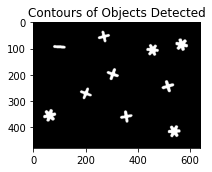

Color: DARKSLATEBLUE (mean: [58, 68, 134])
{2: 3, 3: 2}
Color: DARKSLATEGRAY (mean: [38, 36, 47])
{1: 1, 2: 2, 3: 2}
Vertexs: [20, 16, 22, 16, 16, 16, 8, 18, 20, 16]
Pixels: [1318, 866, 1386, 831, 951, 891, 484, 1226, 1362, 805]

arena-shapes-02


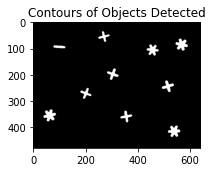

Color: CORNFLOWERBLUE (mean: [114, 134, 223])
{2: 3, 3: 2}
Color: DARKSLATEGRAY (mean: [75, 72, 92])
{1: 1, 2: 2, 3: 2}
Vertexs: [21, 17, 23, 17, 16, 17, 8, 21, 21, 19]
Pixels: [1182, 730, 1237, 677, 857, 775, 403, 1047, 1242, 625]

arena-shapes-03


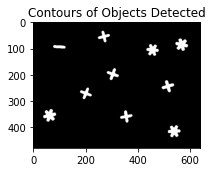

Color: MIDNIGHTBLUE (mean: [38, 44, 87])
{2: 3, 3: 2}
Color: BLACK (mean: [25, 24, 30])
{1: 1, 2: 2, 3: 2}
Vertexs: [20, 17, 22, 16, 17, 16, 8, 21, 21, 17]
Pixels: [1334, 887, 1411, 857, 966, 901, 497, 1253, 1384, 827]


In [28]:
# Implement image analyze for the three images
for i, img in enumerate(images):
    print('\n'+im_names[i])
    src = img
    image_analyze = Img_Analysis()
    contours, vertexs, col_hsv, col_rgb, obj_pixels = image_analyze.analysis(src)
    col_obj_1, col_obj_2, colors, objs = color_filter(col_hsv, col_rgb, contours)
    result_print(vertexs, obj_pixels, col_obj_1, col_obj_2, colors)
    print("Vertexs: {}\nPixels: {}".format(vertexs, obj_pixels))

#### Conclusion

* arena-shapes-01

| -               | Color1                        | Color2                             |
| :-------------- | :---------------------------- | :--------------------------------- |
| Name (mean RGB) | DARKSLATEBLUE ([58, 68, 134]) | DARKSLATEGRAY (mean: [38, 36, 47]) |
| Shape1 (-)      | 0                             | 1                                  |
| Shape2 (+)      | 3                             | 2                                  |
| Shape3 (*)      | 2                             | 2                                  |


* arena-shapes-02

| -               | Color1                        | Color2                             |
| :-------------- | :---------------------------- | :--------------------------------- |
| Name (mean RGB) | CORNFLOWERBLUE ([113, 133, 223]) | DARKSLATEGRAY ([75, 72, 92]) |
| Shape1 (-)      | 0                             | 1                                  |
| Shape2 (+)      | 3                             | 2                                  |
| Shape3 (*)      | 2                             | 2                                  |
        
* arena-shapes-03

| -               | Color1                        | Color2                             |
| :-------------- | :---------------------------- | :--------------------------------- |
| Name (mean RGB) | MIDNIGHTBLUE ([38, 44, 87]) | BLACK ([25, 24, 30]) |
| Shape1 (-)      | 0                             | 1                                  |
| Shape2 (+)      | 3                             | 2                                  |
| Shape3 (*)      | 2                             | 2                                  |

NOTE: 

    1. Objects are sorted from smallest to largest by number of vertices

    2. Color RGB to name using package: webcolors(https://webcolors.readthedocs.io/en/1.11.1/)

### 2.3 Total area (in pixels) of each color (5 pts)

**Some comments of the algorithm... (to be updated)**


arena-shapes-01


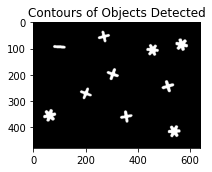

Total area (in pixels) of Color1 is: 5046
Total area (in pixels) of Color2 is: 5074


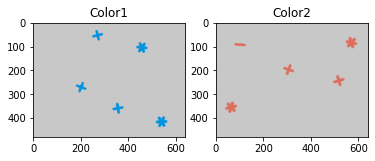


arena-shapes-02


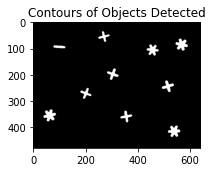

Total area (in pixels) of Color1 is: 4261
Total area (in pixels) of Color2 is: 4514


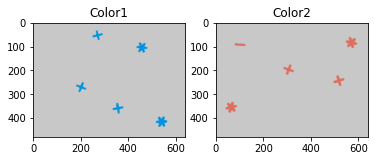


arena-shapes-03


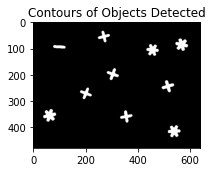

Total area (in pixels) of Color1 is: 5158
Total area (in pixels) of Color2 is: 5159


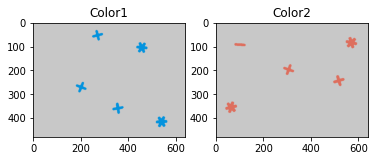

In [27]:
for i, img in enumerate(images):
    print('\n'+im_names[i])
    src = img
    image_analyze = Img_Analysis()
    contours, vertexs, col_hsv, col_rgb, _ = image_analyze.analysis(src)
    col_obj_1, col_obj_2, col, objs = color_filter(col_hsv, col_rgb, contours)
    # # result_print(vertexs, col_obj_1, col_obj_2, col)    
    h, w, ch = img.shape
    titles = ['Color1', 'Color2']
    # Pixels Count and visualization
    for i,cnt in enumerate([objs['col_1'], objs['col_2']]):
        obj_img = np.ones((h, w, ch), dtype=np.uint8)*200
        # cv.drawContours(obj_img, cnt, -1, (), thickness=-1)
        cv.drawContours(obj_img, cnt, -1, (colors[i][0].item(),colors[i][1].item(),colors[i][2].item()), thickness=-1)
        gray = cv.cvtColor(obj_img, cv.COLOR_RGB2GRAY)
        ret, binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV| cv.THRESH_OTSU)
        values, counts = np.unique(binary, return_counts=True)
        print('Total area (in pixels) of {} is: {}'.format(titles[i], counts[1]))

        plt.subplot(1,2,i+1)
        plt.title(titles[i])
        plt.imshow(obj_img)
    plt.show()

#### Result and Analysis
* **Result**

| Images / Pixel number | Color1 | Color2 |
| :-------------------- | :----- | :----- |
| arena-shapes-01       | 5046   | 5074   |
| arena-shapes-02       | 4261   | 4514   |
| arena-shapes-03       | 5158   | 5159   |
    
* **Analysis**

### Reference

1. webcolors: https://webcolors.readthedocs.io/en/1.11.1/